# Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import glob
from PIL import Image, UnidentifiedImageError
import cv2
import seaborn as sns
import zipfile
import shutil
import random


In [2]:
data_dir = 'dataset'

class_names = os.listdir(data_dir)
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


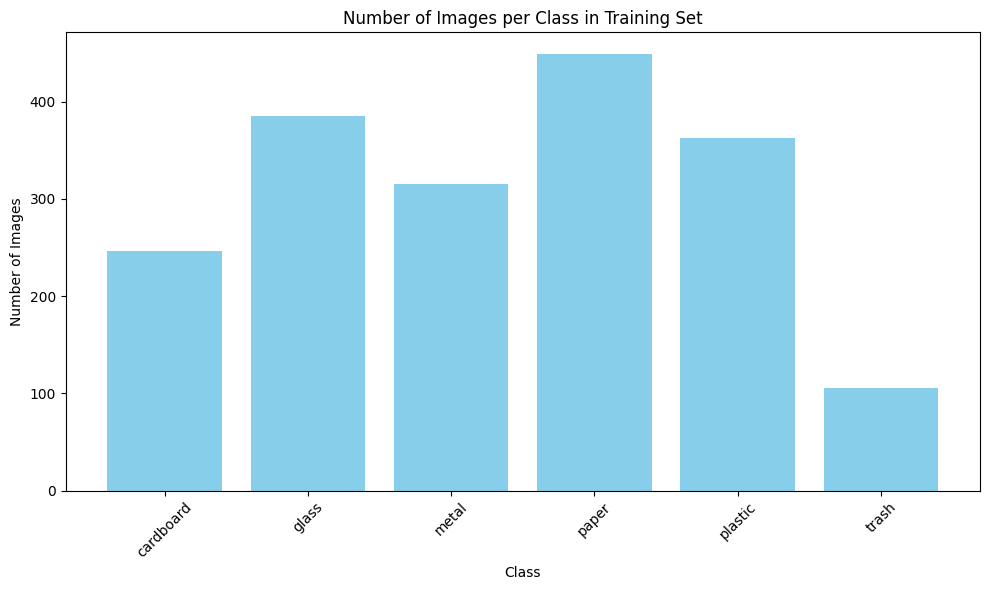

In [3]:
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
img_size = []
corrupted_files = []

for folder in os.listdir(data_dir):
    folder_path = glob.glob(os.path.join(data_dir, folder, '*'))
    for img_path in folder_path:
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                width, height = img.size
                channels = len(img.getbands())
                img_size.append((height, width, channels))
        except (UnidentifiedImageError, OSError) as e:
            print(f"Corrupted file: {img_path} -> {e}")
            corrupted_files.append(img_path)

print(f"corrupted images: {len(corrupted_files)}")

# remove corrupted images
for f in corrupted_files:
    os.remove(f)

# Count image sizes for valid images
size_counts = pd.Series(img_size).value_counts()
print(size_counts)


corrupted images: 0
(384, 512, 3)    1865
Name: count, dtype: int64


# Split Data

In [5]:
output_dir = "split_data"            # Where split dataset will be stored

train_ratio = 0.8
test_ratio = 0.2


In [6]:
for split in ["train", "test"]:
    for folder in os.listdir(data_dir):
        os.makedirs(os.path.join(output_dir, split, folder), exist_ok=True)

for folder in os.listdir(data_dir):
    img_paths = glob.glob(os.path.join(data_dir, folder, "*"))
    random.shuffle(img_paths)
    n = len(img_paths)
    n_train = int(n * train_ratio)

    for i, img_path in enumerate(img_paths):
        if i < n_train:
            dest = os.path.join(output_dir, "train", folder)
        else:
            dest = os.path.join(output_dir, "test", folder)
        shutil.copy(img_path, dest)


In [7]:
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

In [8]:
train_gen= tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)
test_gen= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
train=train_gen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    class_mode='categorical',
    classes=class_names,
    batch_size=32
)
test = test_gen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    class_mode='categorical',
    classes=class_names,
    batch_size=32,
    shuffle=False   # IMPORTANT
)

Found 1701 images belonging to 6 classes.
Found 959 images belonging to 6 classes.


In [10]:
print(train.class_indices)
print(test.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [11]:
class_labels = {v: k for k, v in train.class_indices.items()}  # Reverse the  dictionary
class_labels

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

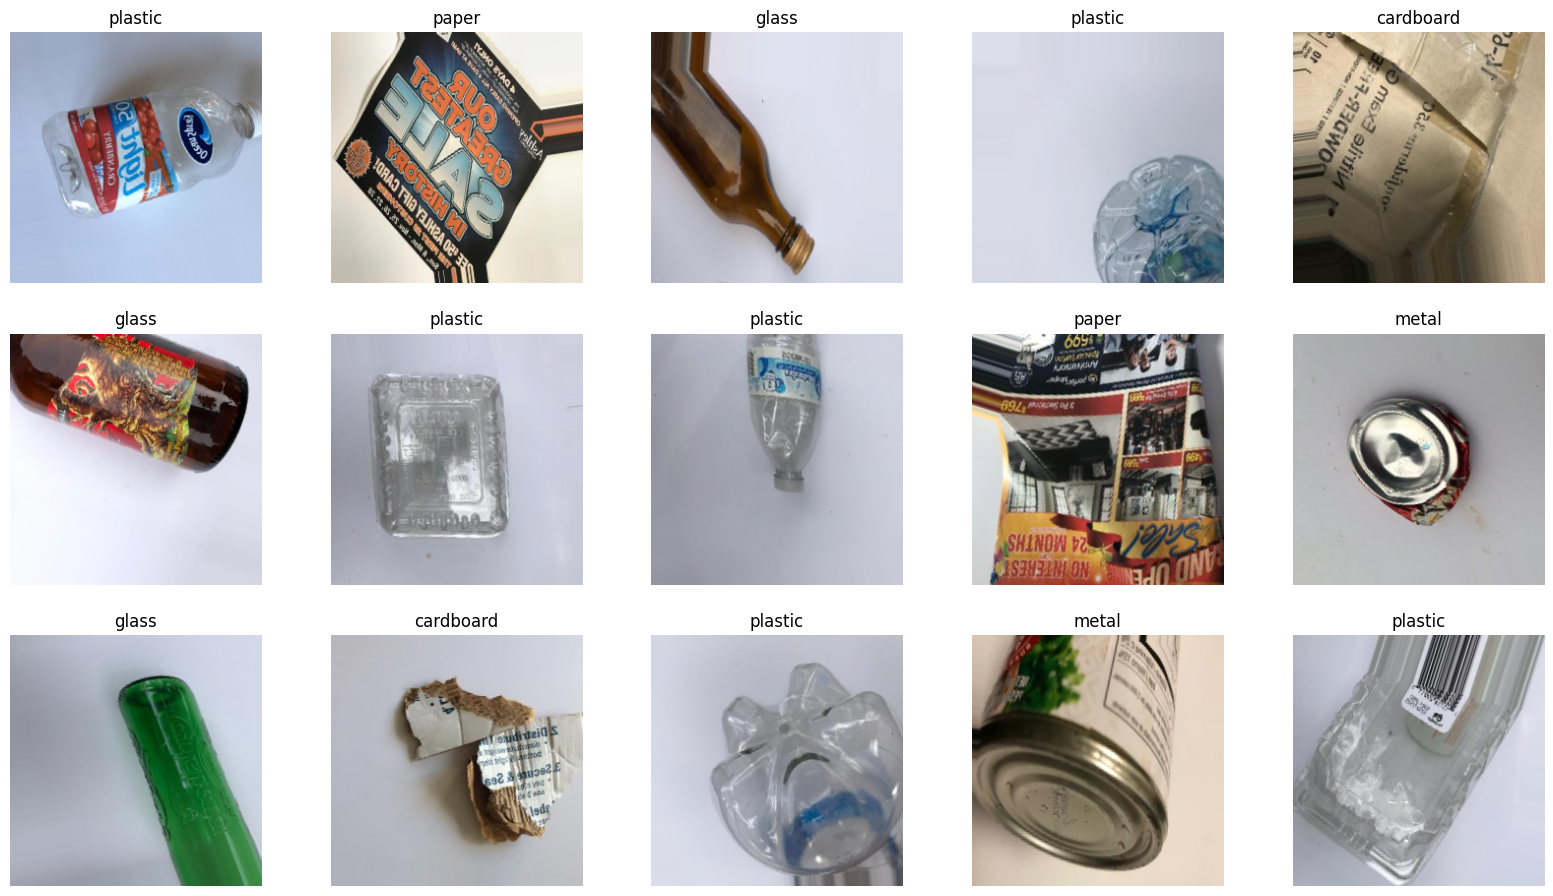

In [12]:
plt.figure(figsize=(20 ,15))
for image_batch, labels_batch in train:
    image = image_batch[1]
    for i in range(1, 16):
        plt.subplot(4, 5, i)
        plt.imshow(image_batch[i])
        label = class_labels[np.argmax(labels_batch[i])]
        plt.title(label)
        plt.axis("off")
    break
    plt.show()

## augmentation impact

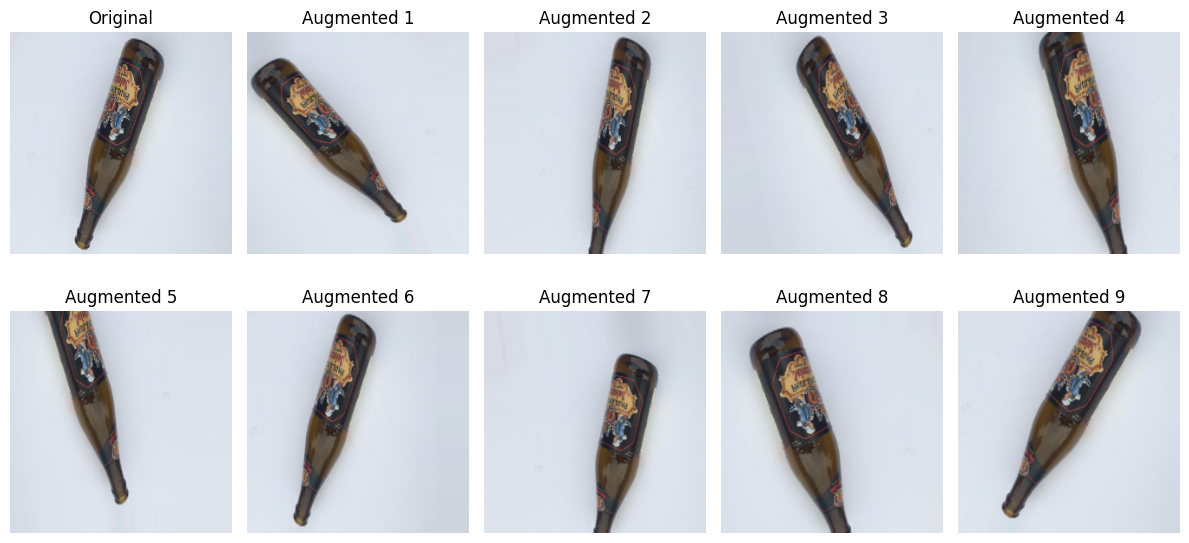

In [13]:
class_folder = os.listdir(train_dir)[1]
image_name = os.listdir(os.path.join(train_dir, class_folder))[1]  # First image in that class
img_path = os.path.join(train_dir, class_folder, image_name)

original_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(original_img)
img_array = np.expand_dims(img_array, axis=0)

augmented_generator = train_gen.flow(
    img_array,
    batch_size=1
)

plt.figure(figsize=(12, 6))

plt.subplot(2, 5, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis('off')

for i in range(9):
    aug_img = next(augmented_generator)[0]
    plt.subplot(2, 5, i + 2)
    plt.imshow(aug_img)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Prepare Data For Model

In [14]:
def extract_data(generator):
    x = []
    y = []
    for i in range(len(generator)):
        imgs, labels = generator[i]
        x.append(imgs)
        y.append(labels)
    x = np.vstack(x)
    y = np.vstack(y)
    return x, y

In [15]:
x_train, y_train = extract_data(train)
x_test, y_test = extract_data(test)

In [16]:
# Flatten images for KNN
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Convert one-hot labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [18]:
knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan')  # you can change n_neighbors
knn.fit(x_train_flat , y_train_int)

# 3️⃣ Predict on test set
y_pred = knn.predict(x_test_flat)

# 4️⃣ Evaluate
acc = accuracy_score(y_test_int, y_pred)
print(f"Accuracy: {acc:.4f}\n")

Accuracy: 0.5443



In [19]:
from sklearn.svm import SVC
# 1️⃣ Scale data (SVM needs it)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled  = scaler.transform(x_test_flat)

# 2️⃣ Train SVM
svm = SVC(kernel='rbf', C=10, gamma='scale')  # you can tune C & gamma
svm.fit(x_train_scaled, y_train_int)

# 3️⃣ Predict
y_pred_svm = svm.predict(x_test_scaled)

# 4️⃣ Evaluate
acc_svm = accuracy_score(y_test_int, y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.4f}\n")



SVM Accuracy: 0.5985

